In [1]:
!pip install boolean.py

In [5]:
import networkx as nx
import boolean as bool
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

In [6]:
class BN:
    """Class representing a Boolean Network (BN) model."""
    __bool_algebra = bool.BooleanAlgebra()

    def __int_to_state(self, x: int) -> tuple[int, ...]:
        """
        Convert a non-negative integer into a Boolean state (tuple of 0s and 1s).

        Args:
            x (int): State number.

        Returns:
            tuple[int, ...]: Tuple of 0s and 1s representing the Boolean network state.
        """
        binary_str = format(x, '0' + str(self.num_nodes) + 'b')
        state = [int(char) for char in binary_str]
        return tuple(state)

    @staticmethod
    def __state_to_binary_str(state: tuple[int, ...]) -> str:
        """
        Convert a Boolean state (tuple) into a binary string.

        Args:
            state (tuple[int, ...]): Tuple of 0s and 1s representing the Boolean network state.

        Returns:
            str: Binary string representation of the Boolean state.
        """
        bin_str = ''.join(str(bit) for bit in state)
        return bin_str

    def __init__(self, list_of_nodes: list[str], list_of_functions: list[str], mode: str):
        """
        Initialize the Boolean Network.

        Args:
            list_of_nodes (list[str]): List of node names.
            list_of_functions (list[str]): List of Boolean expressions for each node,
                e.g. '(x0 & ~x1) | x2', where 'x0', 'x1', and 'x2' are node names.
            mode (str): Update mode, either 'asynchronous' or 'synchronous'.
        """
        self.set_mode(mode)

        self.num_nodes = len(list_of_nodes)
        self.node_names = list_of_nodes

        self.list_of_nodes = [
            self.__bool_algebra.Symbol(node_name) for node_name in list_of_nodes
        ]

        self.functions = [
            self.__bool_algebra.parse(fun, simplify=True) for fun in list_of_functions
        ]

    def set_mode(self, mode: str):
        """
        Set update mode.

        Args:
            mode (str): Update mode, either 'asynchronous' or 'synchronous'.
        """
        assert mode in ['asynchronous', 'synchronous'], "Mode must be 'asynchronous' or 'synchronous'."

        self.mode = mode

    def get_neighbor_states(self, state: tuple[int, ...]) -> set[tuple[int, ...]]:
        """
        Compute all states reachable from the given state in one update.

        Args:
            state (tuple[int, ...]): Tuple of 0s and 1s representing the current state.

        Returns:
            set[tuple[int, ...]]: Set of next states reachable in one step.
        """
        neighbor_states = []
        substitutions = {
            self.list_of_nodes[i]:
                self.__bool_algebra.TRUE if node_value == 1 else self.__bool_algebra.FALSE
            for i, node_value in enumerate(state)
        }

        if self.mode == 'synchronous':
            new_state = []
            for fun in self.functions:
                new_node_value = 1 if fun.subs(
                    substitutions, simplify=True) == self.__bool_algebra.TRUE else 0
                new_state.append(new_node_value)
            neighbor_states.append(new_state)

        else:  # asynchronous
            for node_index, fun in enumerate(self.functions):
                new_node_value = 1 if fun.subs(
                    substitutions, simplify=True) == self.__bool_algebra.TRUE else 0
                new_state = list(state)
                new_state[node_index] = new_node_value
                neighbor_states.append(new_state)

        return set(tuple(ns) for ns in neighbor_states)

    def generate_state_transition_system(self) -> nx.DiGraph:
        """
        Generate the asynchronous state transition system (STS).

        Returns:
            nx.DiGraph: Directed graph (NetworkX DiGraph) representing the STS.
        """
        G = nx.DiGraph()

        for i in range(2**self.num_nodes):
            state = self.__int_to_state(i)
            G.add_node(self.__state_to_binary_str(state))
            neighbor_states = self.get_neighbor_states(state)
            edges = [(
                self.__state_to_binary_str(state),
                self.__state_to_binary_str(neighbor))
                for neighbor in neighbor_states]
            G.add_edges_from(edges)

        return G

    def get_attractors(self) -> list[set[tuple[int]]]:
        """
        Compute asynchronous attractors of the Boolean network.

        Returns:
            list[set[tuple[int]]]: List of attractors. Each attractor is a set of states.
        """
        sts = self.generate_state_transition_system()
        attractors = [attractor for attractor in nx.attracting_components(sts)]
        return attractors

    def draw_state_transition_system(self, highlight_attractors: bool = True) -> None:
        """
        Draw the state transition system.

        Args:
            highlight_attractors (bool, optional): If True, states belonging to different attractors
                are drawn using distinct colors. Defaults to True.

        Returns:
            None
        """
        NON_ATTRACTOR_STATE_COLOR = 'grey'
        sts = self.generate_state_transition_system()

        # Assign colors to attractors if highlighting is enabled
        if highlight_attractors:
            attractors = self.get_attractors()
            sts_nodes = list(sts.nodes)
            node_colors = [NON_ATTRACTOR_STATE_COLOR for _ in sts_nodes]

            colors = list(mcolors.CSS4_COLORS)
            for color_to_remove in ('white', NON_ATTRACTOR_STATE_COLOR):
                if color_to_remove in colors:
                    colors.remove(color_to_remove)

            for attractor in attractors:
                color = random.choice(colors)
                for state in attractor:
                    node_colors[sts_nodes.index(state)] = color

        # Draw the network
        nx.draw_networkx(
            sts,
            with_labels=True,
            pos=nx.spring_layout(sts),
            node_color=node_colors,
            font_size=8
        )

        plt.show()

    def generate_dataset(n_traj: int, length: int, step: int):
        pass


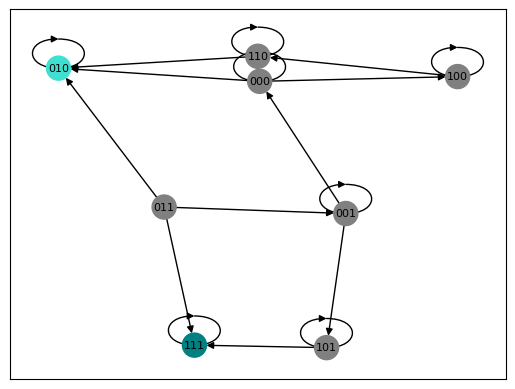

In [12]:
bn = BN(
    ['x0', 'x1', 'x2'],
    ['~x1 | x2', 'x0 | ~x2', 'x0 & x2'],
    'asynchronous'
)

bn.draw_state_transition_system()

In [13]:
def generate_random_functions(list_of_nodes: list[str]) -> list[str]:
    """
    Generate random Boolean functions.

    Args:
        list_of_nodes (list[str]): List of node names.

    Returns:
        list[str]: List of randomly generated Boolean functions.
    """
    MAX_PARENTS = 3
    num_nodes = len(list_of_nodes)
    functions = []

    for _ in range(num_nodes):
        k = random.randint(1, MAX_PARENTS)
        parents = random.sample(list_of_nodes, k)

        # Randomly negate nodes
        terms = []
        for v in parents:
            if random.random() < 0.5:
                terms.append(f'~{v}')
            else:
                terms.append(v)

        # Combine using random operators
        expr = terms[0]
        for t in terms[1:]:
            op = random.choice([' & ', ' | '])
            expr = f'({expr}{op}{t})'

        functions.append(expr)

    return functions

In [15]:
list_of_nodes = ['x0', 'x1', 'x2']
functions = generate_random_functions(list_of_nodes=list_of_nodes)

print(f'list_of_nodes={list_of_nodes}')
print(f'functions={functions}')

list_of_nodes=['x0', 'x1', 'x2']
functions=['((x2 & x0) & ~x1)', '((~x2 & x1) | x0)', '((x1 | ~x0) & x2)']
